# **Final Project**

## **Imports and Helper Functions**

In [10]:
import warnings
warnings.filterwarnings('ignore')
import importlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [25]:
BATCH_SIZE = 8
RESOLUTION = (480, 360)

In [37]:
def plot_images(generator, num_images=9):
    """
    Plots a grid of input, output, and combined images using the provided generator.
    :param generator: An instance of ImageDataGenerator that yields paired input and output images.
    :param num_images: Total number of images to display in a grid (should be a perfect square).
    """
    plt.figure(figsize=(15, 10))  # Adjust the figure size to accommodate the additional images.
    for i in range(num_images):
        batch_window = len(generator)/num_images
        inputs, outputs = generator.__getitem__(np.random.randint(i*batch_window, (i+1)*batch_window))  # Get a random batch.
        print('in:', inputs.shape, 'out:', outputs.shape)
        for j in range(min(len(inputs), num_images - i)):
            # Plot grayscale input image.
            ax = plt.subplot(num_images//3, 9, 3*i + 1 + 3*j)
            plt.imshow(inputs[j].astype('uint8'), cmap='gray')
            plt.title("IN (L)")
            plt.axis('off')

            # Convert LAB AB channels back to RGB for visualization.
            lab_image = np.zeros((RESOLUTION[::-1] + (3,)), dtype=np.uint8)
            lab_image[:, :, 0] = 100  # Set a fixed L channel.
            lab_image[:, :, 1:] = outputs[j]
            rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)
            # Plot AB output image.
            ax = plt.subplot(num_images//3, 9, 3*i + 2 + 3*j)
            plt.imshow(rgb_image)
            plt.title("OUT (AB)")
            plt.axis('off')

            # Create combined image using grayscale as L channel and AB from output
            combined_lab_image = np.zeros((RESOLUTION[::-1] + (3,)), dtype=np.uint8)
            combined_lab_image[:, :, 0] = (cv2.cvtColor(inputs[j], cv2.COLOR_RGB2GRAY))  # Use the grayscale image as the L channel
            combined_lab_image[:, :, 1:] = outputs[j]
            combined_rgb_image = cv2.cvtColor(combined_lab_image, cv2.COLOR_LAB2RGB)
            # Plot combined image
            ax = plt.subplot(num_images//3, 9, 3*i + 3 + 3*j)
            plt.imshow(combined_rgb_image)
            plt.title("Combined (L+AB)")
            plt.axis('off')
            
            if i + j >= num_images - 1:
                break

    plt.tight_layout()
    plt.show()





## **Preprocessing and Augmentation**

in: (32, 360, 480, 3) out: (32, 360, 480, 2)
in: (32, 360, 480, 3) out: (32, 360, 480, 2)
in: (32, 360, 480, 3) out: (32, 360, 480, 2)
in: (32, 360, 480, 3) out: (32, 360, 480, 2)
in: (32, 360, 480, 3) out: (32, 360, 480, 2)
in: (32, 360, 480, 3) out: (32, 360, 480, 2)
in: (32, 360, 480, 3) out: (32, 360, 480, 2)
in: (32, 360, 480, 3) out: (32, 360, 480, 2)
in: (32, 360, 480, 3) out: (32, 360, 480, 2)


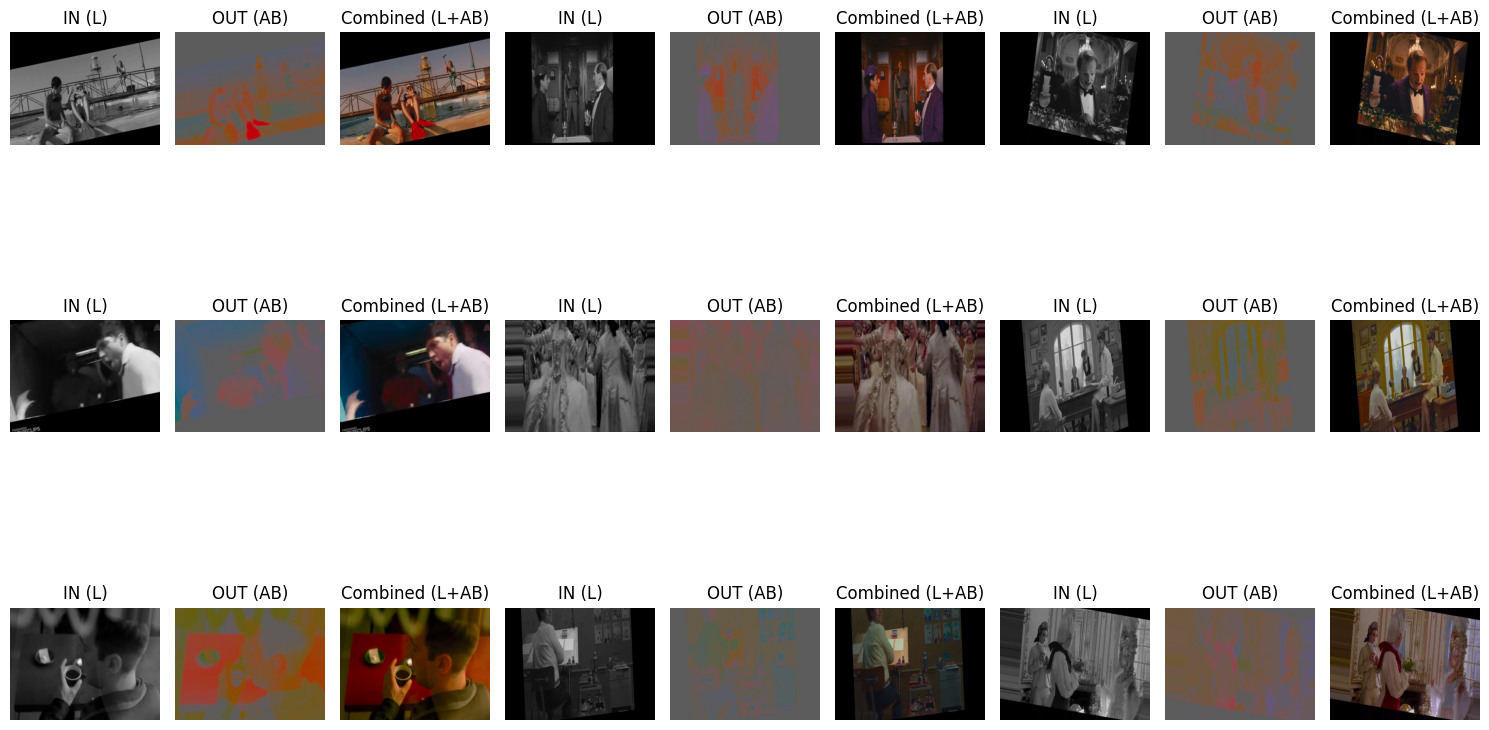

In [38]:
import src.Tyler_ImageDataGenerator as tyler_image_generator
importlib.reload(tyler_image_generator)

# Create data generator
train_directory = 'data/vibrant_movie_frames/rgb'
train_generator = tyler_image_generator.ImageDataGenerator(train_directory, resolution=RESOLUTION)

# Print examples from generator
plot_images(train_generator)


## **Model Architecture**

In [30]:
from keras.layers import Conv2D, UpSampling2D, Input, Lambda, MaxPool2D, Reshape
from keras.models import Sequential, Model
from keras.losses import MeanSquaredError
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam

In [40]:
# Define encoder
#
encoder_input_shape: tuple = (RESOLUTION[::-1] + (3,)) # Add color dim to input shape
encoder: Model = VGG16(include_top=False, weights='imagenet', input_shape=encoder_input_shape)

# Freeze the pretrained layers
# The whole reason we are using VGG16
for layer in encoder.layers:
    layer.trainable = False

# Access the output shape of the encoder
encoder_output_shape = encoder.output_shape[1:] # Drop batch size element
print('VGG16-based encoder input: ' + str(encoder_input_shape))
print('latent shape: ' + str(encoder_output_shape))


# Define decoder
#
decoder = Sequential(
    [
        Input(shape=encoder_output_shape),
        Conv2D(256, (3,3), activation='relu', padding='same'),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(16, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(2, (3, 3), activation='tanh', padding='same'),
        UpSampling2D((2, 2)),
        Lambda(lambda x: tf.image.resize(x, RESOLUTION[::-1], method=tf.image.ResizeMethod.BILINEAR))
    ],
    name='ColorizationDecoder'
)

# Access the output shape of the decoder
decoder_output_shape = decoder.output_shape[1:] # Drop batch size element
print('Decoder output shape: ' + str(decoder_output_shape))

# Summary of models
# encoder.summary()
# decoder.summary()

# Create an encoder-decoder model
input_img = Input(shape=encoder_input_shape)
encoded_img = encoder(input_img)
decoded_img = decoder(encoded_img)

autoencoder = Model(input_img, decoded_img)
autoencoder.compile(optimizer=Adam(), loss='mse')  # Using mean squared error loss, adjust if necessary

VGG16-based encoder input: (360, 480, 3)
latent shape: (11, 15, 512)
Decoder output shape: (360, 480, 2)


## **Training**

In [39]:
# Train the model
history = autoencoder.fit(
    x=train_generator,
    epochs=10,  # Set the number of epochs according to your needs
    steps_per_epoch=len(train_generator),
    verbose=1
)

Epoch 1/10
 2/91 ━━━━━━━━━━━━━━━━━━━━ 10:35 7s/step - loss: 17905.2793 

KeyboardInterrupt: 

## **Training**

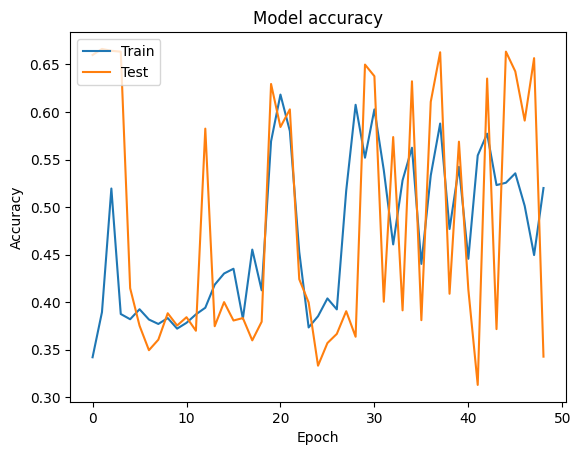

In [10]:
# Plot training & validation accuracy values
plt.plot(stack.final_history.history['accuracy'])
plt.plot(stack.final_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

15/15 [==============================] - 1s 91ms/step


ValueError: num must be an integer with 1 <= num <= 30, not 31

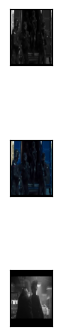

In [13]:


predictions = stack.final_model.predict(stack.bw_test_list)
predictions.shape

n = 10
plt.figure(figsize=(35, 25))
for i in range(n):
    show = 20+i*20
    # Display original gray images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(stack.bw_test_list[show], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display original color images
    ax = plt.subplot(3, n, i + 1 + n)
    
    plt.imshow(stack.test_list[show])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display pred images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    
    plt.imshow(predictions[show])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig('result.png')

## **Prediction**

In [12]:
'''Calls prediction fucntions in prediction.py and methods from result'''
predictor = Predictor(model_path='path/to/saved/model')
input_data = 'path/to/input/data'
predictions = predictor.predict(input_data)

NameError: name 'Predictor' is not defined

## **Validation**

In [ ]:
'''Calls the validation fuctions in validation.py and methods from result'''
validator = Validator(model_path='path/to/saved/model')
validation_data = 'path/to/validation/data'
evaluation_metrics = validator.validate(validation_data)